# 1. Overall density profile of a given year NOT USED JUST MAYBE FOR LATER

To be in accordance with TEOS-10 it translates from Salinity_[psu] & Temp_[°C] into Absolute_Salinity [g/kg] & Conservative_Temp_deg [°C]. As sources I used the TEOS-10 book, some ChatGPT, lots of StackOverflow or Python Library Documentations (which I can easily quote), and also Work/Study coding experience for which giving sources like "my own memory" isnt feasible.

I did later integrate this into the buoyancy frequency calculation. But I saved it here because I initially thought to code them all in individual cells.

### Futility
This cell stands like a mausoleum in the notebook. An empty monument to purpose lost. Its imports now hollow echoes of once-needed power, its functions ghosts repeating a ritual whose god has died. Nothing calls it, nothing depends on it, and yet it remains, proud and decaying, a cathedral of abandoned syntax that pretends to matter while the living code has already moved on. The later cells no longer look back; the computations no longer seek its guidance. It endures only as a relic. Proof that even in the cold precision of programming, obsolescence can linger like grief, and a script can keep breathing long after its heart has stopped.


/tmp/ipykernel_27218/1792004885.py:115: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loaded ArcticOcean_phys_oce_1980.txt with 282231 levels

Profile overview:
                        source_file  Prof_no          Cruise Station Platform  \
0     ArcticOcean_phys_oce_1980.txt      490       G.O._SARS    0158        S   
1     ArcticOcean_phys_oce_1980.txt      491       G.O._SARS    0059        S   
2     ArcticOcean_phys_oce_1980.txt      492    OTTO_SCHMIDT    0575        S   
3     ArcticOcean_phys_oce_1980.txt      493    MICHAEL_SARS    0198        S   
4     ArcticOcean_phys_oce_1980.txt      494    MICHAEL_SARS    0215        S   
...                             ...      ...             ...     ...      ...   
6560  ArcticOcean_phys_oce_1980.txt   183399  ANTON_DOHRN_II     NaN        S   
6561  ArcticOcean_phys_oce_1980.txt   183610  ANTON_DOHRN_II     NaN        S   
6562  ArcticOcean_phys_oce_1980.txt   183608  ANTON_DOHRN_II     NaN        S   
6563  ArcticOcean_phys_oce_1980.txt   183602  ANTON_DOHRN_II     NaN        S   
6564  ArcticOcean_phys_oce_1980.tx

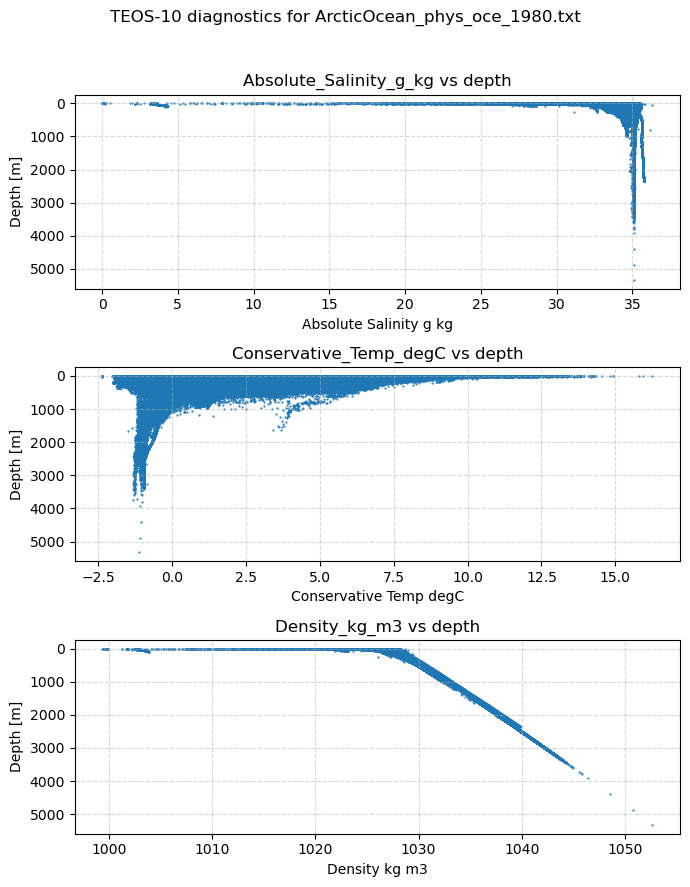

In [76]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Optional, Sequence
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt

# Warn when raw measurements look suspicious
import warnings

# Directory
PROFILE_TEXT_FILE = Path("UDASH/ArcticOcean_phys_oce_1980.txt")
DEFAULT_UDASH_FILE = PROFILE_TEXT_FILE

# List pertaining names so a notebook can `from udash_density import ...
__all__ = [
    "UDASH_COLUMNS",
    "UDASHProfileMetadata",
    "PROFILE_TEXT_FILE",
    "DEFAULT_UDASH_FILE",
    "load_udash_file",
    "load_default_profile",
    "iter_profile_metadata",
    "summarize_profiles",
    "preview_profile_metadata",
    "preview_level_samples",
    "plot_teos10_diagnostics",
    "save_teos10_variables",
]

# List every column name once for reference
UDASH_COLUMNS = {
    "profile": "Prof_no",
    "cruise": "Cruise",
    "station": "Station",
    "platform": "Platform",
    "instrument_type": "Type",
    "timestamp": "yyyy-mm-ddThh:mm",
    "longitude_deg": "Longitude_[deg]",
    "latitude_deg": "Latitude_[deg]",
    "pressure_dbar": "Pressure_[dbar]",
    "depth_m": "Depth_[m]",
    "temperature_degC": "Temp_[°C]",
    "salinity_psu": "Salinity_[psu]",
    "quality_flag": "QF",
}

@dataclass
class UDASHProfileMetadata:
    """Keep basic profile metadata in an object with attributes"""
    profile: int
    cruise: str
    station: str
    platform: str
    instrument_type: str
    timestamp: str
    longitude_deg: float
    latitude_deg: float

def _infer_profile_year(df: pd.DataFrame) -> str:
    """Grab first timestamp and year for filename"""
    ts_name = UDASH_COLUMNS["timestamp"]
    if ts_name not in df:
        return "unknown"
    timestamps = pd.Series(df[ts_name]).dropna().astype(str)
    if timestamps.empty:
        return "unknown"
    first = timestamps.iloc[0]
    try:
        return str(pd.to_datetime(first).year)
    except (TypeError, ValueError):
        return str(first)[:4]

def save_teos10_variables(
    df: pd.DataFrame,
    *,
    source_path: Path,
    output_root: Path = Path("Density"),
) -> Path:
    """Dump the useful columns into `Density/<year>_file_teos10.txt"""
    year = _infer_profile_year(df)
    output_root.mkdir(parents=True, exist_ok=True)
    output_path = output_root / f"{year}_{source_path.stem}_teos10.txt"

    columns = [
        UDASH_COLUMNS["longitude_deg"],
        UDASH_COLUMNS["latitude_deg"],
        UDASH_COLUMNS["pressure_dbar"],
        UDASH_COLUMNS["depth_m"],
        UDASH_COLUMNS["salinity_psu"],
        UDASH_COLUMNS["temperature_degC"],
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
        "Potential_Density_kg_m3",
    ]
    present = [name for name in columns if name in df.columns]
    df[present].to_csv(output_path, sep="\t", index=False, float_format="%.6f")
    return output_path

def load_udash_file(
    path: str | Path,
    *,
    missing_value: float = -999.0,
    drop_na: bool = True,
    save_output: bool = True,
    output_root: Path = Path("Density"),
    raise_on_negative_salinity: bool = False,
) -> pd.DataFrame:
    """Read one UDASH file, clean it, run TEOS-10, save it"""
    # Koad the raw text file using pandas for immediate DataFrame
    path = Path(path)
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        na_values=[missing_value],
        engine="python",
    )

    # Strip out rows that are missing any of the key TEOS-10 inputs
    salinity_name = UDASH_COLUMNS["salinity_psu"]
    required = [
        salinity_name,
        UDASH_COLUMNS["temperature_degC"],
        UDASH_COLUMNS["pressure_dbar"],
        UDASH_COLUMNS["longitude_deg"],
        UDASH_COLUMNS["latitude_deg"],
    ]
    if drop_na:
        df = df.dropna(subset=[col for col in required if col in df])

    # Sort by depth (with pressure as a backup)
    sort_keys = [
        key
        for key in (UDASH_COLUMNS["depth_m"], UDASH_COLUMNS["pressure_dbar"])
        if key in df
    ]
    if sort_keys:
        df = df.sort_values(sort_keys).reset_index(drop=True)

    # Convert the relevant columns into NumPy arrays for gsw
    SP = df[salinity_name].to_numpy(float)
    p = df[UDASH_COLUMNS["pressure_dbar"]].to_numpy(float)
    lon = df[UDASH_COLUMNS["longitude_deg"]].to_numpy(float)
    lat = df[UDASH_COLUMNS["latitude_deg"]].to_numpy(float)
    t = df[UDASH_COLUMNS["temperature_degC"]].to_numpy(float)

    # Changes faulty values to NaN
    # Latitude [-90, 90]
    if (lat < -90).any() or (lat > 90).any():
        warnings.warn("Latitude values outside [-90, 90] found; masking.", RuntimeWarning)
        lat = np.where((lat < -90) | (lat > 90), np.nan, lat)

    # Longitude [-180, 360]
    if (lon < -180).any() or (lon > 360).any():
        warnings.warn("Longitude values outside [-180, 360] found; masking.", RuntimeWarning)
        lon = np.where((lon < -180) | (lon > 360), np.nan, lon)

    # Pressure [0, 12000] dbar (safe ocean range)
    if (p < -5).any() or (p > 12000).any():
        warnings.warn("Pressure values outside [0, 12000] dbar found; masking.", RuntimeWarning)
        p = np.where((p < 0) | (p > 12000), np.nan, p)

    # Practical Salinity [0, 50]
    if (SP < 0).any() or (SP > 50).any():
        warnings.warn("Practical Salinity values outside [0, 50] found; masking.", RuntimeWarning)
        SP = np.where((SP < 0) | (SP > 50), np.nan, SP)

    # In-situ Temperature [-5, 40] °C (covers typical ocean)
    if (t < -5).any() or (t > 40).any():
        warnings.warn("Temperature values outside [-5, 40] °C found; masking.", RuntimeWarning)
        t = np.where((t < -5) | (t > 40), np.nan, t)

    # TEOS-10 conversions: Absolute Salinity, Conservative Temperature, density
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)
    sigma0 = gsw.sigma0(SA, CT) + 1000.0  # I use potential density referenced to the surface.

    # Attach the new columns
    df = df.copy()
    df.insert(0, "source_file", path.name)
    df["Absolute_Salinity_g_kg"] = SA
    df["Conservative_Temp_degC"] = CT
    df["Density_kg_m3"] = rho
    df["Potential_Density_kg_m3"] = sigma0

    # (no negative_rows anymore) – record lightweight QC info and a validity flag
    df.attrs["qc_counts"] = {
        "latitude_masked": int(np.isnan(lat).sum()),
        "longitude_masked": int(np.isnan(lon).sum()),
        "pressure_masked": int(np.isnan(p).sum()),
        "salinity_masked": int(np.isnan(SP).sum()),
        "temperature_masked": int(np.isnan(t).sum()),
    }
    df["valid_for_teos10"] = (
        np.isfinite(SP) & np.isfinite(t) & np.isfinite(p) & np.isfinite(lon) & np.isfinite(lat)
    )

    # Save the processed columns for reusage in other scripts
    if save_output:
        output_path = save_teos10_variables(df, source_path=path, output_root=output_root)
        df.attrs["teos10_output_path"] = str(output_path)

    return df
    
# Now it´s working towards plotting and printing the data
# Courtesy to ChatGPT
def load_default_profile(
    *,
    missing_value: float = -999.0,
    drop_na: bool = True,
    save_output: bool = True,
    output_root: Path = Path("Density"),
    raise_on_negative_salinity: bool = False,
) -> pd.DataFrame:
    """Call :func:load_udash_file with the profile path set above"""
    return load_udash_file(
        PROFILE_TEXT_FILE,
        missing_value=missing_value,
        drop_na=drop_na,
        save_output=save_output,
        output_root=output_root,
        raise_on_negative_salinity=raise_on_negative_salinity,
    )
# Courtesy to ChatGPT
def preview_profile_metadata(df: pd.DataFrame, *, max_rows: Optional[int] = 10) -> pd.DataFrame:
    """ChatGPT: List the distinct profile metadata rows for a quick sanity check."""
    columns = [
        "source_file",
        UDASH_COLUMNS["profile"],
        UDASH_COLUMNS["cruise"],
        UDASH_COLUMNS["station"],
        UDASH_COLUMNS["platform"],
        UDASH_COLUMNS["instrument_type"],
    ]
    # ChatGPT: Drops duplicates so one profile does not flood the output with all depths.
    preview = df.loc[:, columns].drop_duplicates().reset_index(drop=True)
    if max_rows is not None:
        # Trim the preview unless explicitly asked for every row
        preview = preview.head(max_rows)
    return preview

def preview_level_samples(df: pd.DataFrame, *, samples: int = 12) -> pd.DataFrame:
    """Pick evenly spaced levels"""
    if samples <= 0 or df.empty:
        return df.head(0)
    if samples >= len(df):
        return df
    # Indices between the first and last rows
    idx = np.linspace(0, len(df) - 1, samples)
    # Round and deduplicate the indices before subsetting
    unique_idx = np.unique(idx.round().astype(int))
    return df.iloc[unique_idx]

# Courtesy to ChatGPT
def iter_profile_metadata(df: pd.DataFrame) -> Iterable[UDASHProfileMetadata]:
    """Emit one metadata record per profile to iterate cleanly"""
    seen: set[tuple[int, str]] = set()
    for _, row in df.iterrows():
        key = (int(row[UDASH_COLUMNS["profile"]]), row["source_file"])
        if key in seen:
            continue
        seen.add(key)
        yield UDASHProfileMetadata(
            profile=key[0],
            cruise=str(row[UDASH_COLUMNS["cruise"]]),
            station=str(row[UDASH_COLUMNS["station"]]),
            platform=str(row[UDASH_COLUMNS["platform"]]),
            instrument_type=str(row[UDASH_COLUMNS["instrument_type"]]),
            timestamp=str(row[UDASH_COLUMNS["timestamp"]]),
            longitude_deg=float(row[UDASH_COLUMNS["longitude_deg"]]),
            latitude_deg=float(row[UDASH_COLUMNS["latitude_deg"]]),
        )

def summarize_profiles(df: pd.DataFrame, *, by: Optional[str] = "source_file") -> pd.DataFrame:
    """Summarise each profile with counts and min/max values"""
    group_columns = [by] if by else [UDASH_COLUMNS["profile"], "source_file"]
    summary = (
        df.groupby(group_columns)
        .agg(
            n_levels=(UDASH_COLUMNS["pressure_dbar"], "size"),
            min_pressure=(UDASH_COLUMNS["pressure_dbar"], "min"),
            max_pressure=(UDASH_COLUMNS["pressure_dbar"], "max"),
            min_density=("Density_kg_m3", "min"),
            max_density=("Density_kg_m3", "max"),
        )
        .reset_index()
    )
    return summary

# Actual plotting part
def plot_teos10_diagnostics(
    df: pd.DataFrame,
    *,
    columns: Sequence[str] = (
        "Absolute_Salinity_g_kg",
        "Conservative_Temp_degC",
        "Density_kg_m3",
    ),
    depth_column: str = UDASH_COLUMNS["depth_m"],
    share_depth_axis: bool = True,
    figsize: tuple[float, float] = (7.0, 9.0),
    marker: str = "o",
    marker_size: float = 0.3,
):

    missing = [name for name in columns if name not in df]
    if missing:
        raise KeyError(f"Missing required columns: {', '.join(missing)}")
    if depth_column not in df:
        raise KeyError(f"Depth column '{depth_column}' not found in DataFrame")

    fig, axes = plt.subplots(len(columns), 1, figsize=figsize, sharey=share_depth_axis)
    if len(columns) == 1:
        axes = [axes]

    depth = df[depth_column]
    for ax, name in zip(axes, columns):
        ax.scatter(df[name], depth, s=marker_size, marker=marker)
        ax.set_xlabel(name.replace("_", " "))
        ax.set_ylabel("Depth [m]")
        ax.set_title(f"{name} vs depth")
        ax.invert_yaxis()
        ax.grid(True, linestyle="--", alpha=0.5)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    return fig, axes

if __name__ == "__main__":
    df = load_default_profile()

    file_name = PROFILE_TEXT_FILE.name
    print(f"Loaded {file_name} with {len(df)} levels\n")

    # Show metadata to see which profile the file contains
    print("Profile overview:")
    print(preview_profile_metadata(df, max_rows=None))
    print()

    # Preview representative depth levels without printing the entire table
    print("Sampled profile levels:")
    with pd.option_context("display.max_columns", None, "display.width", None):
        print(preview_level_samples(df, samples=12))
    print()

    # Path
    output_path = df.attrs.get("teos10_output_path")
    if output_path:
        print(f"Saved TEOS-10 variables to: {output_path}\n")

    # Level counts and density ranges.
    print("Density summary:")
    print(
        summarize_profiles(df, by=None)[
            [
                UDASH_COLUMNS["profile"],
                "source_file",
                "n_levels",
                "min_pressure",
                "max_pressure",
                "min_density",
                "max_density",
            ]
        ]
    )


    # 3 scatter plots with tiny dots so individual depths show up
    fig, _ = plot_teos10_diagnostics(df)
    fig.suptitle(f"TEOS-10 diagnostics for {file_name}", y=0.98)
    fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])

    # Store in D_figs for convenience
    figs_dir = Path("D_figs")
    figs_dir.mkdir(parents=True, exist_ok=True)
    year = _infer_profile_year(df)
    fig_path = figs_dir / f"{year}_{Path(file_name).stem}_teos10_plots.png"
    fig.savefig(fig_path, dpi=300)
    df.attrs["diagnostic_figure_path"] = str(fig_path)
    print(f"Saved TEOS-10 diagnostic figure to: {fig_path}")

    plt.show()


# 2. Buoyancy Frequency Calculation ###

We get negative values no matter how?!

Sources are mainly the TEOS-10 .io page and the TEOS-10 full book, Chelton et al. 1997 and Vallis page 100 were used for the buoyancy frequency equation. None of them explain negative buoyancy frequencies.

Maybe the Git Repository https://github.com/opinner/Code_to_Pinner_et_al_2025/tree/main might be of help. Yet here, they did not have to calculate either the density, nor the absolute salinity, and methods of calculation these two were note mentioned. The dataset https://doi.pangaea.de/10.1594/PANGAEA.742580?format=html#lcol9_ds11144595 would solve error propagation of density calculations and  salinity calculations, as Absolute Salinity and Density pertaining to TEOS-10 are already involved. So to sum up, N2 calculation yes, Density No.

I thus tried to fetch the data in the first cells, then use gsw notation to calculate all variables while keeping them geo-referencede. Then, as sanity checks, I plotted all results. Lastly, error calculation is detremental.


## Explanations

After experimenting a lot the safest approach seems to be to stick to the gsw functions and insert sanity checks for negative N2 values afterwards.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gsw
from pathlib import Path
import os

plt.rcParams.update({"figure.figsize": (6,6), "axes.grid": True})

outdir = Path("Buoyancy_Freq")
outdir.mkdir(exist_ok=True)


Read and clean UDASH text file and replaces -999 with NaN. Then Load and Define given file


In [102]:
def read_udash_file(path):
    df = pd.read_csv(path, sep=r"\s+|\t|,", engine="python")
    df = df.replace(-999, np.nan)
    cols = [
        "Prof_no","Longitude_[deg]","Latitude_[deg]",
        "Pressure_[dbar]","Depth_[m]","Temp_[°C]","Salinity_[psu]"
    ]
    df = df[cols].rename(columns={
        "Longitude_[deg]": "lon",
        "Latitude_[deg]": "lat",
        "Pressure_[dbar]": "p",
        "Depth_[m]": "z",
        "Temp_[°C]": "t",
        "Salinity_[psu]": "SP"
    })
    return df

udash_path = Path("UDASH/ArcticOcean_phys_oce_1980.txt")
df = read_udash_file(udash_path)
print(f"Loaded {len(df)} rows from {udash_path.name}")


Loaded 299216 rows from ArcticOcean_phys_oce_1980.txt


Now this cell is to compute Absolute Salinity, Conservative Temperature, and density. I safe them as well and just print out a neat statistic to kinda have a sanity check.


In [103]:
def compute_teos_properties(df):
    SA = gsw.SA_from_SP(df["SP"], df["p"], df["lon"], df["lat"])
    CT = gsw.CT_from_t(SA, df["t"], df["p"])
    rho = gsw.rho(SA, CT, df["p"])
    return SA, CT, rho

df["SA"], df["CT"], df["rho"] = compute_teos_properties(df)

print(df[["SA","CT","rho"]].describe().round(3))


            SA        CT      rho
count 2.82e+05  2.82e+05 2.82e+05
mean  3.46e+01  1.24e+00 1.03e+03
std   1.47e+00  2.52e+00 3.22e+00
min   1.40e-02 -2.37e+00 9.99e+02
25%   3.44e+01 -7.92e-01 1.03e+03
50%   3.50e+01  6.02e-01 1.03e+03
75%   3.51e+01  2.58e+00 1.03e+03
max   3.63e+01  1.63e+01 1.05e+03


Overall this is where we now compute the Buoyancy Frequency.
In the TEOS-10 documentation it states that gsw.Nsquared(SA, CT, p, lat) expects numpay arrays and not those funny sounding "panda series", thus one shall rewrite said variables for the convenience of IT. We do have to sort them by pressure as this function computes finite differences between consecutive pressure levels. As in Chelton 1997 I chose to store and calculate them at midpoint depths, with most of the calculations done here being a direct inspiration from https://github.com/opinner/Code_to_Pinner_et_al_2025/blob/main/scripts/IDEMIX_parameterization/average%20N%20calculation.ipynb

DataFrame then pairs all your computed arrays into columns of equal length.
Afterwards, one creates a list and simply checks that each cast/profile has more than 3 measurements, so that one can at least calculate 2 buoyancy frequencies. Otherwise it would be meaningless.

In [104]:
def compute_N2(df):
    df = df.sort_values("p").dropna(subset=["SA","CT","p","lat"])
    SA = df["SA"].to_numpy(float)
    CT = df["CT"].to_numpy(float)
    p = df["p"].to_numpy(float)
    lat = df["lat"].mean()

    N2, p_mid = gsw.Nsquared(SA, CT, p, lat)
    N = np.sqrt(np.clip(N2, 0, np.inf))

    z_mid = -gsw.z_from_p(p_mid, lat)

    dfN2 = pd.DataFrame({
        "p_mid": p_mid,
        "z_mid": z_mid,
        "N2_s^-2": N2,
        "N_s^-1": N
    })
    return dfN2

N2_list = []
for pid, g in df.groupby("Prof_no"):
    if g["p"].count() < 3:
        continue
    try:
        N2_list.append(compute_N2(g))
    except Exception:
        continue

dfN2 = pd.concat(N2_list, ignore_index=True)
print(f"Computed N^2 for {len(dfN2)} midpoint levels.")


Computed N² for 275494 midpoint levels.


As another sanity check I´d like to print the statistics of the results. I gotta import re (Courtesy to ChatGPT), ensure the output folder exists and lastly fetch the year right from the UDASH file name, which spares me the agony of handwriting it and which is also the reason I asked ChatGPT to import re for.

Then np.interp is to interpolate SA, CT, and ρ onto the N² mid-pressure grid p_mid so rows line up, for which of course all the rows got to be named and defined again.

This is then saved in a .txt file, where I again used ChatGPT for "df_out.to_csv(n2_txt_path, sep=" ", index=False, float_format="%.6f")" as it needs that for some reason.


In [114]:
summary = dfN2[["N2_s^-2", "N_s^-1"]].describe(percentiles=[.25, .5, .75]).T.round(6)
print(summary)

import re

outdir.mkdir(exist_ok=True)

def _infer_year_tag():
    candidates = []
    if "udash_path" in globals():
        try:
            candidates.append(Path(udash_path).name)
        except Exception:
            pass
    candidates.append(Path(summary_path).name)
    for name in candidates:
        m = re.search(r"(\d{4})", str(name))
        if m:
            return m.group(1)
    return "all"

year_tag = _infer_year_tag()


lat = df["lat"].mean()
lon = df["lon"].mean() if "lon" in df.columns else np.nan

df_out = pd.DataFrame({
    "Absolute_Salinity_[g/kg]": np.interp(dfN2["p_mid"], df["p"], df["SA"]),
    "Latitude_[deg]": lat,
    "Longitude_[deg]": lon,
    "Conservative_Temperature_[°C]": np.interp(dfN2["p_mid"], df["p"], df["CT"]),
    "In-situ_Density_[kg m^-3]": np.interp(dfN2["p_mid"], df["p"], df["rho"]),
    "Pressure_[dbar]": dfN2["p_mid"],
    "Depth_[m]": dfN2["z_mid"],
    "N2_[s^-2]": dfN2["N2_s^-2"]
})

n2_txt_path = outdir / f"N2_{year_tag}.txt"
df_out.to_csv(n2_txt_path, sep=" ", index=False, float_format="%.6f")

print(f"Saved N^2 file with {len(df_out)} rows to {n2_txt_path.resolve()}")
print("Columns:", " | ".join(df_out.columns))


           count     mean      std       min      25%      50%      75%  \
N2_s^-2 2.75e+05 6.40e-05 9.51e-04 -7.58e-02 0.00e+00 4.00e-06 2.20e-05   
N_s^-1  2.75e+05 3.99e-03 7.58e-03  0.00e+00 2.45e-04 1.89e-03 4.74e-03   

             max  
N2_s^-2 2.50e-01  
N_s^-1  5.00e-01  
Saved summary to /home/rill/Buoyancy_Freq/Buoyancy_frequency_summary_1980.csv
Saved UDASH-like N² file with 275494 rows to /home/rill/Buoyancy_Freq/N2_1980.txt
Columns: Absolute_Salinity_[g/kg] | Latitude_[deg] | Longitude_[deg] | Conservative_Temperature_[°C] | In-situ_Density_[kg m^-3] | Pressure_[dbar] | Depth_[m] | N2_[s^-2]


Plotting something always helps with visualization and understanding. Since every year has so many probes I decided for scatter plots with especially small dots fixed in dot_style. 
Again, one needs to infer the year tag, which I did with ChatGPT.
The pertaining plotting part is trivial, only the locator/formatter block is explained more detailed: It customizes the x-axis of a Matplotlib plot that’s meant to show values spanning several orders of magnitude.
These plots are then not just shown, but also saved as one individual .png.

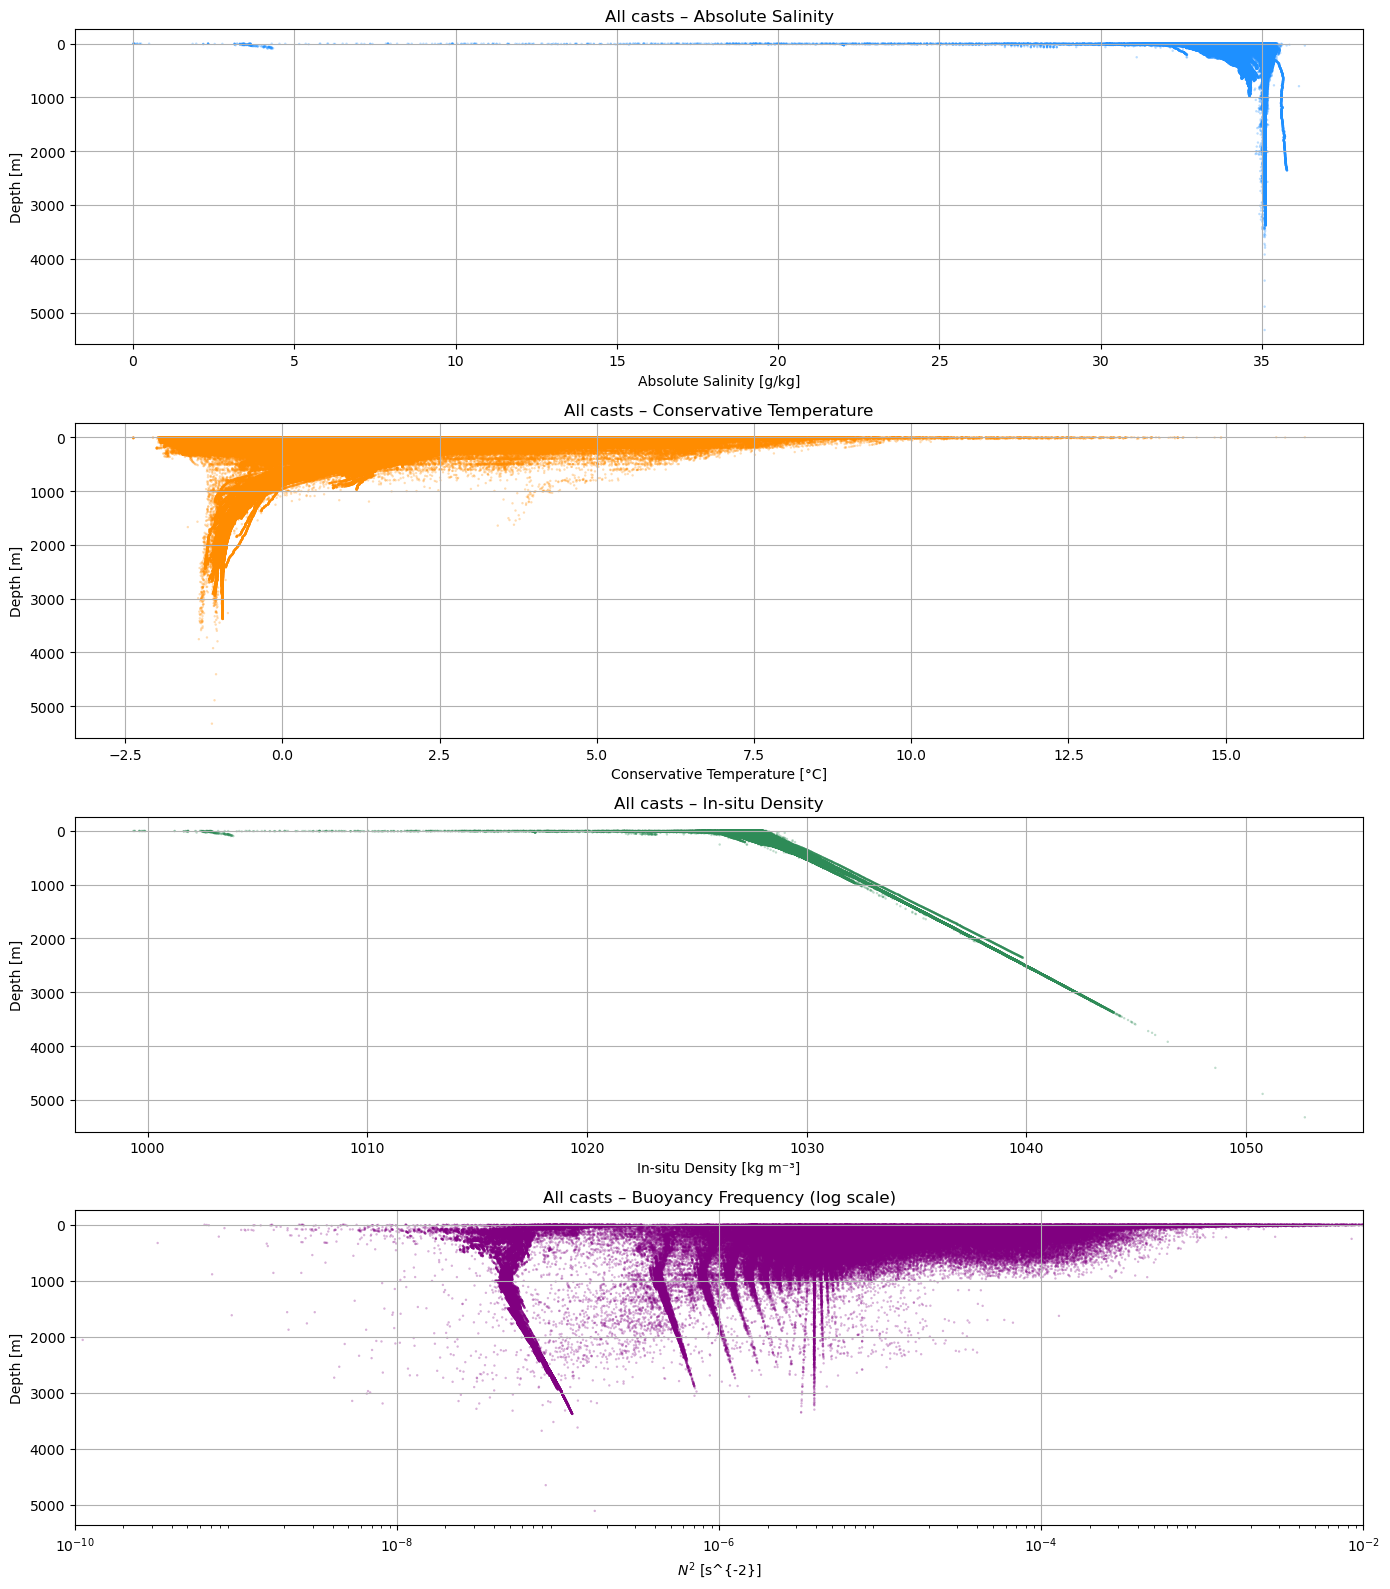

Saved combined figure to /home/rill/D_figs/1980.png


In [113]:
import matplotlib.ticker as ticker

dot_style = dict(s=3, alpha=0.3, edgecolors="none")

year_tag = "all"
try:
    if "year" in globals() and str(year).isdigit():
        year_tag = str(year)
    elif "udash_path" in globals():
        m = re.search(r"(\d{4})", str(udash_path))
        if m:
            year_tag = m.group(1)
except Exception:
    pass

fig, axes = plt.subplots(4, 1, figsize=(14, 16))  

# 1) Absolute Salinity vs Depth
ax = axes[0]
ax.scatter(df["SA"], -gsw.z_from_p(df["p"], df["lat"]), **dot_style, color="dodgerblue")
ax.invert_yaxis()
ax.set_xlabel("Absolute Salinity [g/kg]")
ax.set_ylabel("Depth [m]")
ax.set_title("Absolute Salinity")

# 2) Conservative Temperature vs Depth
ax = axes[1]
ax.scatter(df["CT"], -gsw.z_from_p(df["p"], df["lat"]), **dot_style, color="darkorange")
ax.invert_yaxis()
ax.set_xlabel("Conservative Temperature [°C]")
ax.set_ylabel("Depth [m]")
ax.set_title("Conservative Temperature")

# 3) In situ Density vs Depth
ax = axes[2]
ax.scatter(df["rho"], -gsw.z_from_p(df["p"], df["lat"]), **dot_style, color="seagreen")
ax.invert_yaxis()
ax.set_xlabel("In-situ Density [kg m⁻³]")
ax.set_ylabel("Depth [m]")
ax.set_title("In-situ Density")

# 4) Buoyancy Frequency N² (log scale) vs Depth
ax = axes[3]
ax.scatter(dfN2["N2_s^-2"], dfN2["z_mid"], **dot_style, color="purple")
ax.invert_yaxis()
ax.set_xscale("log")
ax.set_xlabel(r"$N^2$ [s^{-2}]")
ax.set_ylabel("Depth [m]")
ax.set_title("Buoyancy Frequency")

ax.set_xlim(1e-10, 1e-2)
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()

fig_dir = Path("D_figs")
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / f"{year_tag}.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()
print(f"Saved combined figure to {out_path.resolve()}")


It might be necessary to have an error bar, so thats what I do here. Below are just explanations for new functions.

Regarding the "detect casts" part: 
If Prof_no exists then I use it directly, otherwise this snippet can detect where pressure resets to shallower values, split the data there, and create fake profile IDs.

To build N^2 stack it iterates through every detected cast ID (either from the "Prof_no" column or from the reconstructed segments list), extracts each cast’s valid subset of mid-depth (z_mid) and buoyancy frequency squared (N2_s^-2) values (skipping those with fewer than three usable points), sorts them by depth to ensure monotonicity, interpolates each N² profile onto a common vertical grid (comparison_depth) filling out-of-range regions with NaN, accumulates all these interpolated profiles into the list N2_stack, converts that list into a NumPy array for stacked analysis (e.g., averaging or contour plotting), and finally raises a RuntimeError if no valid casts were found — thus ensuring that only properly structured, comparable N² profiles are kept for later cross-profile comparison or visualization. Courtesy to ChatGPT not for coding, but for explaining what to do.

/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tmp/ipykernel_27218/1536114552.py:55: RuntimeWarning: Mean of empty slice
  mean_N2 = np.nanmean(N2_stack, axis=0)
/home/conda/envs/ocean/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


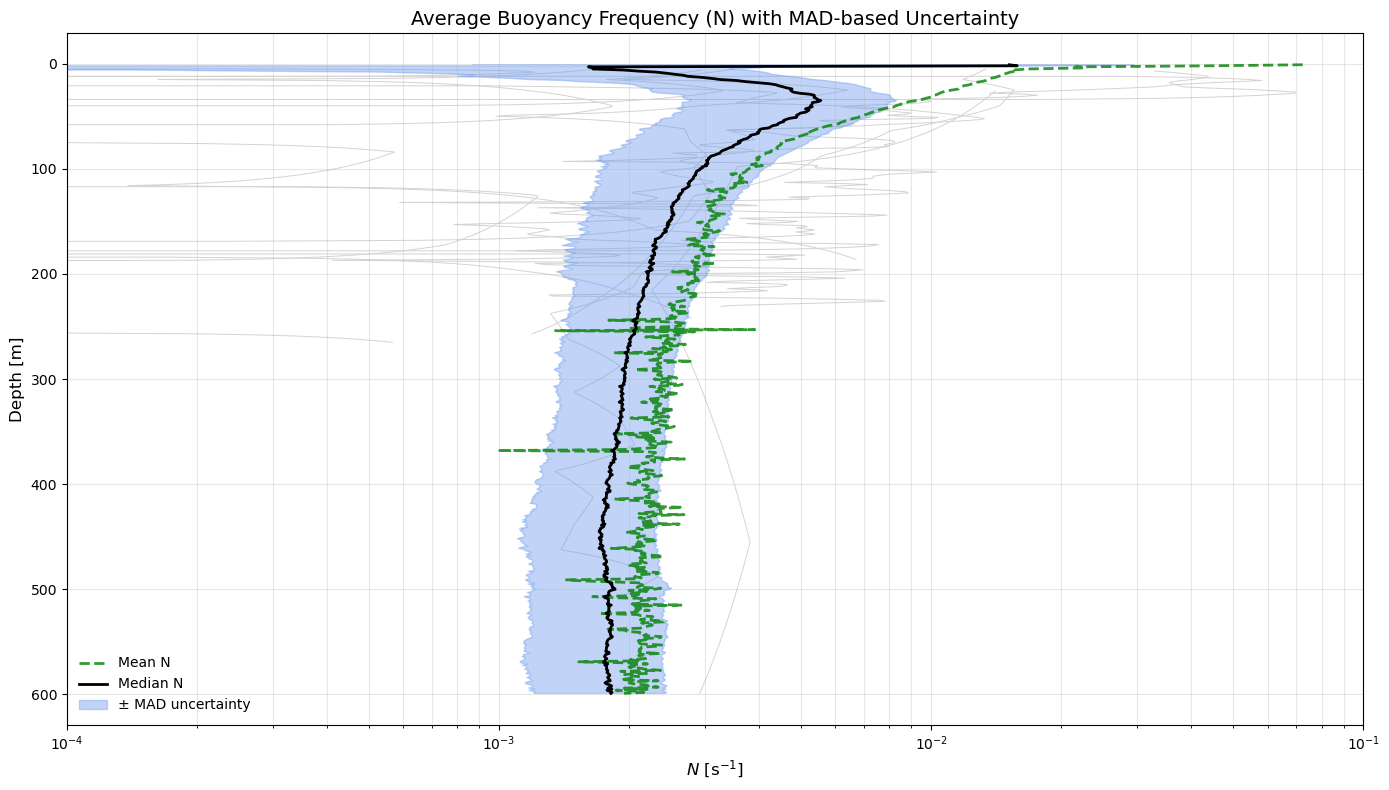

Saved average-N figure with uncertainty to /home/rill/D_figs/Average_N_with_uncertainty_1980.png


In [123]:
# infer year tag
year_tag = "all"
try:
    if "year" in globals() and str(year).isdigit():
        year_tag = str(year)
    elif "udash_path" in globals():
        m = re.search(r"(\d{4})", str(udash_path))
        if m:
            year_tag = m.group(1)
except Exception:
    pass

# detect casts (via Prof_no or pressure resets) 
if "Prof_no" in dfN2.columns:
    cast_ids = dfN2["Prof_no"].unique()
else:
    pvals = dfN2["p_mid"].values
    breaks = np.where(np.diff(pvals) < 0)[0] + 1
    segments = np.split(dfN2, breaks)
    cast_ids = np.arange(len(segments))

# define depth grid 
comparison_depth = np.arange(0, 600, 1)

# build N² stack per cast
N2_stack = []
for i, cid in enumerate(cast_ids):
    if "Prof_no" in dfN2.columns:
        subset = dfN2[dfN2["Prof_no"] == cid].dropna(subset=["z_mid", "N2_s^-2"])
    else:
        subset = segments[i].dropna(subset=["z_mid", "N2_s^-2"])
    if len(subset) < 3:
        continue

    z = subset["z_mid"].to_numpy()
    N2 = subset["N2_s^-2"].to_numpy()
    order = np.argsort(z)
    z, N2 = z[order], N2[order]

    N2_interp = np.interp(comparison_depth, z, N2, left=np.nan, right=np.nan)
    N2_stack.append(N2_interp)

N2_stack = np.array(N2_stack)
if N2_stack.size == 0:
    raise RuntimeError("No valid casts with N² data found in dfN2.")

# calculate mean, median, and uncertainties 
mean_N2 = np.nanmean(N2_stack, axis=0)
median_N2 = np.nanmedian(N2_stack, axis=0)
mad_N2 = np.nanmedian(np.abs(N2_stack - median_N2), axis=0)

median_N = np.sqrt(np.clip(median_N2, 0, np.inf))
mean_N = np.sqrt(np.clip(mean_N2, 0, np.inf))
with np.errstate(divide="ignore", invalid="ignore"):
    delta_N_mad = 0.5 * mad_N2 / np.where(median_N > 0, median_N, np.nan)

# create figure 
fig, ax = plt.subplots(figsize=(14, 8))

# Individual casts (light grey)
for row in N2_stack[np.random.choice(len(N2_stack), min(8, len(N2_stack)), replace=False)]:
    ax.plot(np.sqrt(np.clip(row, 0, np.inf)), comparison_depth, color="lightgrey", lw=0.7, zorder=1)

# Mean & median
ax.plot(mean_N, comparison_depth, "g--", lw=2, alpha=0.8, label="Mean N")
ax.plot(median_N, comparison_depth, "k", lw=2, label="Median N")

# Uncertainty band
ax.fill_betweenx(
    comparison_depth,
    median_N - delta_N_mad,
    median_N + delta_N_mad,
    color="cornflowerblue",
    alpha=0.4,
    label="± uncertainty"
)

# axis formatting (LOG scale) 
ax.set_xscale("log")
ax.set_xlim(1e-4, 1e-1)  
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.invert_yaxis()
ax.set_xlabel(r"$N$ [s$^{-1}$]", fontsize=12)
ax.set_ylabel("Depth [m]", fontsize=12)
ax.set_title("Average Buoyancy Frequency (N) with MAD-based Uncertainty", fontsize=14)
ax.grid(True, which="both", alpha=0.3)
ax.legend(frameon=False, loc="best")

plt.tight_layout()

# save ONE PNG per year in D_figs 
fig_dir = Path("D_figs")
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / f"{year_tag}-Average_N_with_uncertainty_.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()
print(f"Saved average-N figure with uncertainty to {out_path.resolve()}")


# 3. Creating the Eigenvalue Problem

This will need a few days of literature recherche and reading into, as we are now entering the not so well documented realms.